In [1]:
pip install nltk

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [2]:
from sklearn.model_selection import KFold
from sklearn.metrics import confusion_matrix
import numpy as np
import math
np.random.seed(42)

In [3]:
import nltk
import numpy as np

nltk.download('brown')
nltk.download('universal_tagset')

from nltk.corpus import brown

# Access the Brown Corpus with the Universal POS tagset
brown_corpus = brown.tagged_sents(tagset='universal')
brown_corpus = np.array(brown_corpus, dtype = object)
possible_tags = ['NOUN', 'VERB','ADV', 'ADJ', 'PRT', 'DET', 'CONJ', '.', 'ADP', 'PRON', 'X', 'NUM']

[nltk_data] Downloading package brown to /home/pulkit/nltk_data...
[nltk_data]   Package brown is already up-to-date!
[nltk_data] Downloading package universal_tagset to
[nltk_data]     /home/pulkit/nltk_data...
[nltk_data]   Package universal_tagset is already up-to-date!


In [4]:
def training(train):
    # word_tag corresponds to tag - word prob
    word_tag = {}
    for i in train:
        for j in i:
            if j[1] not in word_tag:
                word_tag[j[1]] = {}
            if j[0].lower() not in word_tag[j[1]]:
                word_tag[j[1]][j[0].lower()] = 0
            word_tag[j[1]][j[0].lower()]+=1
    for x in word_tag:
        tot = 0
        for j in word_tag[x]:
            tot += word_tag[x][j]
        word_tag[x]['Total'] = tot
    
    
    trans = {}
    trans['^'] = {}
    word_tag['^'] = {}
    word_tag['^']['Total'] = len(train)
    
    for i in train:
        if i[0][1] not in trans['^']:
            trans['^'][i[0][1]] = 0
        trans['^'][i[0][1]]+=1
        if len(i) <= 1:
            continue
        for x in range(len(i)-1):
            if i[x][1] not in trans:
                trans[i[x][1]] = {}
            if i[x+1][1] not in trans[i[x][1]]:
                trans[i[x][1]][i[x+1][1]] = 0
            trans[i[x][1]][i[x+1][1]]+=1
    return word_tag, trans

In [5]:
def lex_prob(word, tag, word_tag):
    if word in word_tag[tag]:
        return word_tag[tag][word]/word_tag[tag]['Total']
    else:
        return 1e-9

In [6]:
def trans_prob(curr_tag, prev_tag, trans, total):
    if curr_tag not in trans[prev_tag]:
        return 1e-9
    else:
        return trans[prev_tag][curr_tag] / total

In [8]:
def Viterbi_predict(word_tag, trans, sentence_train = None, sentence = None):
    if sentence_train is not None:
        n = 0
        for i in sentence_train:
            n += 1
        sentence = sentence_train
    
    else:
        words = str.split(sentence, ' ')
        sentence = []
        for x in words:
            sentence.append((x, 0))
        n = len(sentence)
    
    curr_tag = [['^', 0]]
    new_tag = []
    #curr_max = -1e10000
    max_entries = 4
    curr_entries = 1
    
    possible_tags = ['NOUN', 'VERB','ADV', 'ADJ', 'PRT', 'DET', 'CONJ', '.', 'ADP', 'PRON', 'X', 'NUM']
    ans_tag = []
    
    for i in range(n):
        word = sentence[i][0].lower()
        for poss in curr_tag:
            for j in possible_tags:
                prob = poss[-1]
                prev_tag = poss[-2]
                copy_poss = poss.copy()
                
                prob += math.log(lex_prob(word, j, word_tag)) + math.log(trans_prob(j, prev_tag, trans, word_tag[j]['Total']))
                copy_poss[-1] = j
                copy_poss.append(prob)
                new_tag.append(copy_poss)
        curr_tag = sorted(new_tag, key = lambda r:r[-1], reverse = True)[:max_entries]
        #print(word, '->', curr_tag)
        new_tag = []
    final_tag = curr_tag[0][:-1]
    final_tag = final_tag[1:]
    #print(len(final_tag))
    return final_tag
        

In [9]:
def get_confusion_matrix(all_preds, all_vals):
    possible_tags = ['NOUN', 'VERB','ADV', 'ADJ', 'PRT', 'DET', 'CONJ', '.', 'ADP', 'PRON', 'X', 'NUM']
    cm = confusion_matrix(all_vals, all_preds, labels = possible_tags)
    return cm

In [10]:
kf = KFold(n_splits=5, shuffle = True)
split = kf.split(brown_corpus)

In [11]:
def know_vals(d):
    l = []
    for i in d:
        l.append(i[1])
    return l

In [12]:
def get_scores(confusion_matrix):
    precision_scores = {}
    recall_scores = {}
    f1_scores = {}
    possible_tags = ['NOUN', 'VERB','ADV', 'ADJ', 'PRT', 'DET', 'CONJ', '.', 'ADP', 'PRON', 'X', 'NUM']
    
    for i in range(12):
        correct = confusion_matrix[i, i]
        false_pos = np.sum(confusion_matrix[:, i]) - correct
        false_neg = np.sum(confusion_matrix[i, :]) - correct
        precision = correct / (correct + false_pos)
        recall = correct / (correct + false_neg)
        tag = possible_tags[i]
        precision_scores[tag] = precision
        recall_scores[tag] = recall

        # Calculate F1 score for each class
        f1 = 2 * (precision * recall) / (precision + recall)
        f1_scores[tag] = f1
    
    return precision_scores, recall_scores, f1_scores

In [13]:
from sklearn.metrics import fbeta_score
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score as ps

In [14]:
ind_prec = [0,0,0,0,0]
ind_recall = [0,0,0,0,0]
ind_f1score = [0,0,0,0,0]
cnt = 0
cm = [0,0,0,0,0]

f1_score = f2_score = prec = recall = fhalf_score = 0

for train, test in split:
    #train_data, test_data = brown_corpus[train], brown_corpus[test]
    train_data, test_data = brown_corpus[train], brown_corpus[test]
    word_tag, trans = training(train_data)
    all_vals = []
    all_preds = []
    suc = 0
    tot = 0
    for d in test_data:
        vals = know_vals(d)
        pred = Viterbi_predict(word_tag, trans, sentence_train = d)
        if(vals == pred):
            suc += 1
        tot += 1
        #print(len(vals), len(pred))
        all_vals.extend(vals)
        all_preds.extend(pred)
    print(suc/tot)
    cm[cnt] = get_confusion_matrix(all_preds, all_vals)
    f1_score += fbeta_score(all_vals, all_preds, beta = 1, average = 'weighted')
    fhalf_score += fbeta_score(all_vals, all_preds, beta = 0.5, average = 'weighted')
    f2_score += fbeta_score(all_vals, all_preds, beta = 2, average = 'weighted')
    prec += ps(all_vals, all_preds, average = 'weighted')
    recall += recall_score(all_vals, all_preds, average = 'weighted')
    print(cm[cnt])
    ind_prec[cnt], ind_recall[cnt], ind_f1score[cnt] = get_scores(cm[cnt])
    cnt += 1
    
    #print('Metrics and scores for 5-fold-cross-validation sets : ')
    #print(f'F1 score - {fbeta_score(all_vals, all_preds, beta = 1, average = "weighted")}')
    #print(f'F2 score - {fbeta_score(all_vals, all_preds, beta = 2, average = "weighted")}')
    #print(f'F0.5 score - {fbeta_score(all_vals, all_preds, beta = 0.5, average = "weighted")}')
    #print(f'Precision score - {ps(all_vals, all_preds, average = "weighted")}')
    #print(f'Recall score - {recall_score(all_vals, all_preds, average = "weighted")}')
    #print(ind_prec[cnt-1])
    #print(ind_recall[cnt-1])
    #print(ind_f1score[cnt-1])

f1_score /= 5.0
fhalf_score /= 5.0
prec /= 5.0
recall /= 5.0
f2_score /= 5.0

print('Overall scores : ')
print(f'F1 score - {f1_score}')
print(f'F2 score - {f2_score}')
print(f'F0.5 score - {fhalf_score}')
print(f'Precision score - {prec}')
print(f'Recall score - {recall}')

print()
print('Overall Individual Scores:')
iprec = {}
irecall = {}
if1score = {}
for i in possible_tags:
    iprec[i] = irecall[i] = if1score[i] = 0
    for j in range(5):
        iprec[i] += ind_prec[j][i]
        irecall[i] += ind_recall[j][i]
        if1score[i] += ind_f1score[j][i]
    iprec[i]/=5.0
    if1score[i]/=5.0
    irecall[i] /= 5.0

print(iprec)
print(irecall)
print(if1score)


0.4956400418555982
[[51475   762   286   963    29   280    67   268   143   292    79   178]
 [  997 35050   182   175     3    72    65    50   115    29     2     4]
 [   22    38 10185   431   159    43    20    15   337    21     0     0]
 [  351   128   576 15389    50   120    66    13    38    36     2     3]
 [   31     8    44     1  5371     2     3     0   374    18     1     0]
 [    0     0    24     0     0 27111     7     0   126   204     2     0]
 [    0     0    35     0     0    15  7476     0     3     0     0     0]
 [    0     0     0     0     0     0     0 29492     0     0    28     0]
 [    7    21   439    18   728    61    22     3 27398    61    10     0]
 [    6     2     0     0     0    58     0     1   105  9761     0     1]
 [   63    25     4    15     4    13     5     9    12    24   152     3]
 [   42    13    20    28     0    53    11    21     7    28     4  2684]]
0.4985176142309034
[[51722   829   295   958    27   328    93   302   169   257

In [52]:
confusion_matrix = (cm[0] + cm[1] + cm[2] + cm[3] + cm[4])//5

In [16]:
import matplotlib.pyplot as plt
import seaborn as sns

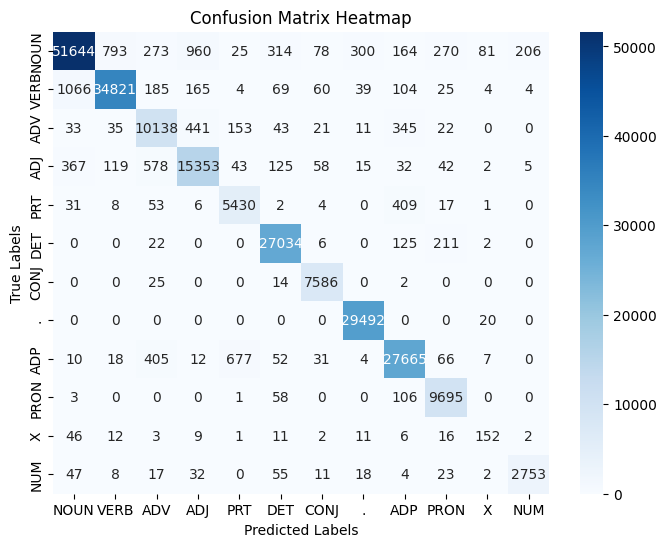

In [50]:
plt.figure(figsize=(8, 6))
ax = sns.heatmap(confusion_matrix, annot=True, fmt='d', cmap='Blues')

# Set axis labels and title
ax.set_xlabel('Predicted Labels')
ax.set_ylabel('True Labels')
plt.title('Confusion Matrix Heatmap')
ax.set_xticklabels(possible_tags)
ax.set_yticklabels(possible_tags)

# Show the heatmap
plt.show()

In [53]:
confusion_matrix = np.array(confusion_matrix, dtype = 'float64')
s = np.sum(confusion_matrix, axis = 1)
s *= 1.0
for i in range(12):
    for j in range(12):
        confusion_matrix[i][j] = round(confusion_matrix[i][j]/s[i], 2)
print(confusion_matrix)        

[[0.94 0.01 0.   0.02 0.   0.01 0.   0.01 0.   0.   0.   0.  ]
 [0.03 0.95 0.01 0.   0.   0.   0.   0.   0.   0.   0.   0.  ]
 [0.   0.   0.9  0.04 0.01 0.   0.   0.   0.03 0.   0.   0.  ]
 [0.02 0.01 0.03 0.92 0.   0.01 0.   0.   0.   0.   0.   0.  ]
 [0.01 0.   0.01 0.   0.91 0.   0.   0.   0.07 0.   0.   0.  ]
 [0.   0.   0.   0.   0.   0.99 0.   0.   0.   0.01 0.   0.  ]
 [0.   0.   0.   0.   0.   0.   0.99 0.   0.   0.   0.   0.  ]
 [0.   0.   0.   0.   0.   0.   0.   1.   0.   0.   0.   0.  ]
 [0.   0.   0.01 0.   0.02 0.   0.   0.   0.96 0.   0.   0.  ]
 [0.   0.   0.   0.   0.   0.01 0.   0.   0.01 0.98 0.   0.  ]
 [0.17 0.04 0.01 0.03 0.   0.04 0.01 0.04 0.02 0.06 0.56 0.01]
 [0.02 0.   0.01 0.01 0.   0.02 0.   0.01 0.   0.01 0.   0.93]]


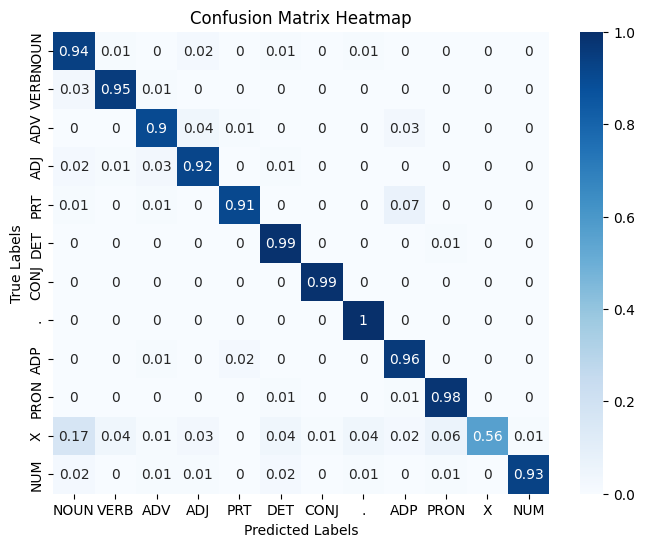

In [54]:
plt.figure(figsize=(8, 6))
ax = sns.heatmap(confusion_matrix, annot=True, cmap='Blues')

# Set axis labels and title
ax.set_xlabel('Predicted Labels')
ax.set_ylabel('True Labels')
plt.title('Confusion Matrix Heatmap')
ax.set_xticklabels(possible_tags)
ax.set_yticklabels(possible_tags)

# Show the heatmap
plt.show()

In [26]:
train_data = brown_corpus
word_tag, trans = training(train_data)

In [37]:
sentence = "What are you doing ?"
Viterbi_predict(word_tag, trans, sentence = sentence)

['DET', 'VERB', 'PRON', 'VERB', '.']